# Map of Flights Taken

The goal of this post is to visualize flights taken from Google location data using Python
* This post utilizes code from Tyler Hartley's [visualizing location history blog post](http://beneathdata.com/how-to/visualizing-my-location-history/) 

# Overview 

1. Setup
    * download data
    * install modules
2. Data Wrangling
    * data extraction
    * data exploration
    * data manipulation
3. Flight Algorithm
4. Visualize Flights
5. Conclusion

# Setup
1. Use Google Takout to download your Google location history
* If you've previously enabled Google location reporting on your smartphone, your GPS data will be periodically uploaded to [Google's servers](https://support.google.com/accounts/answer/3118687?hl=en&visit_id=1-636109809748631344-4285616029&rd=1). Use Google Takeout to download your location history.
    * The decisions of when and how to upload this data are entirely obfuscated to the end user, but as you'll see below, Android appears to upload a GPS location every 60 seconds. That's plenty of data to work with.
2. After downloading your data, install the required modules

## Google Takeout
Google [Takeout](https://takeout.google.com/settings/takeout) is a Google service that allows users to export any personal Google data. We'll use Takeout to download our raw location history as a one-time snapshot. Since Latitude was retired, no API exists to access location history in real-time. 

Download location data:
* Go to [takeout](https://www.google.com/settings/takeout). Uncheck all services except "Location History" 
* The data will be in a json format, which works great for us. Download it in your favorite compression type.
* When Google has finished creating your archive, you'll get an email notification and a link to download. 
* Download and unzip the file, and you should be looking at a `LocationHistory.json` file. Working with location data in [Pandas](http://pandas.pydata.org/). Pandas is an incredibly powerful tool that simplifies working with complex datatypes and performing statistical analysis in the style of R. Chris Albon has great primers on using Pandas [here](http://chrisalbon.com/#Python) under the "Data Wrangling" section.

## Install modules
* If you use Anaconda to manage your Python packages, I recommend creating a virtual environment with anaconda to install the dependencies. Copying the lines below the instruction into the terminal creates the environment, requirements.txt, etc.
    * conda create -n test-env python=3.5 anaconda
    * source activate test-env
* make a requirements.txt file for dependencies 
    * (echo descartes; echo IPython; echo shapely; echo fiona; echo Basemap) >> requirements.txt  
* install requirements.txt
    * conda install --yes --file requirements.txt

After completing the setup, we'll read in the `LocationHistory.json` file from Google Takeout and create a DataFrame.

In [1]:
import json
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from IPython.display import Image
import fiona
from shapely.prepared import prep
from descartes import PolygonPatch
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
import warnings
warnings.filterwarnings('ignore')

# Data Wrangling
* data extraction

In [2]:
with open('LocationHistory.json', 'r') as fh:
    raw = json.loads(fh.read())

# use location_data as an abbreviation for location data
location_data = pd.DataFrame(raw['locations'])
del raw #free up some memory

# convert to typical units
location_data['latitudeE7'] = location_data['latitudeE7']/float(1e7) 
location_data['longitudeE7'] = location_data['longitudeE7']/float(1e7)
location_data['timestampMs'] = location_data['timestampMs'].map(lambda x: float(x)/1000) #to seconds
location_data['datetime'] = location_data.timestampMs.map(datetime.datetime.fromtimestamp)

# Rename fields based on the conversions we just did
location_data.rename(columns={'latitudeE7':'latitude', 'longitudeE7':'longitude', 'timestampMs':'timestamp'}, inplace=True)
location_data = location_data[location_data.accuracy < 1000] #Ignore locations with accuracy estimates over 1000m
location_data.reset_index(drop=True, inplace=True)

## Explore Data
* view data and datatypes

In [3]:
location_data.head()

,accuracy,activity,altitude,heading,latitude,longitude,timestamp,velocity,datetime
0,21,"[{'timestampMs': '1503180210463', 'activity': ...",NaN,NaN,47.664788,-122.346873,1.503180e+09,NaN,2017-08-19 15:03:32.631
1,21,"[{'timestampMs': '1503180149925', 'activity': ...",NaN,NaN,47.664788,-122.346873,1.503180e+09,NaN,2017-08-19 15:01:31.487
2,21,"[{'timestampMs': '1503179967778', 'activity': ...",65.0,NaN,47.664791,-122.346896,1.503180e+09,NaN,2017-08-19 14:59:29.852
3,21,"[{'timestampMs': '1503179844537', 'activity': ...",69.0,NaN,47.664788,-122.346873,1.503180e+09,NaN,2017-08-19 14:57:23.436
4,19,"[{'timestampMs': '1503178357753', 'activity': ...",63.0,NaN,47.661274,-122.313973,1.503178e+09,0.0,2017-08-19 14:30:41.000


In [4]:
location_data.dtypes

accuracy              int64
activity             object
altitude            float64
heading             float64
latitude            float64
longitude           float64
timestamp           float64
velocity            float64
datetime     datetime64[ns]
dtype: object

In [5]:
location_data.describe()

,accuracy,altitude,heading,latitude,longitude,timestamp,velocity
count,716017.000000,83282.000000,35498.000000,716017.000000,716017.000000,7.160170e+05,46791.000000
mean,59.556770,33.147823,190.420869,37.611641,-105.131568,1.413964e+09,7.548140
std,125.760722,184.995795,103.330412,9.051446,16.496591,2.838440e+07,11.326376
min,1.000000,-715.000000,0.000000,13.689757,-123.260751,1.376790e+09,0.000000
25%,23.000000,-20.000000,98.000000,29.817567,-122.306606,1.390437e+09,0.000000
50%,31.000000,-6.000000,188.000000,29.817867,-95.253652,1.412290e+09,1.000000
75%,51.000000,37.000000,273.000000,47.664313,-94.995611,1.425326e+09,12.000000
max,999.000000,6738.000000,359.000000,50.105984,8.675475,1.503180e+09,208.000000


* accuracy code "999" may represent missingness  
* find earliest and latest observations in the data
    * save for later

In [6]:
print("earliest observed date: {}".format(min(location_data["datetime"]).strftime('%m-%d-%Y')))
print("latest observed date: {}".format(max(location_data["datetime"]).strftime('%m-%d-%Y')))

earliest_obs = min(location_data["datetime"]).strftime('%m-%d-%Y')
latest_obs = max(location_data["datetime"]).strftime('%m-%d-%Y')

earliest observed date: 08-17-2013
latest observed date: 08-19-2017


* data manipulation

### Degrees and Radians

* We're going to convert the degree-based geo data to radians to calculate distance traveled. I'm going to paraphrase an explanation (source below) about why the degree-to-radians conversion is necessary
    * Degrees are arbitrary because they’re based on the sun and backwards because they are from the observer’s perspective.
    * Radians are in terms of the mover allowing equations to “click into place”. Converting rotational to linear speed is easy, and ideas like sin(x)/x make sense.
 
Consult [this post](https://betterexplained.com/articles/intuitive-guide-to-angles-degrees-and-radians/) for more info about degrees and radians in distance calculation.
    
* convert degrees to radians

In [7]:
degrees_to_radians = np.pi/180.0 
location_data['phi'] = (90.0 - location_data.latitude) * degrees_to_radians 
location_data['theta'] = location_data.longitude * degrees_to_radians
# Compute distance between two GPS points on a unit sphere
location_data['distance'] = np.arccos(
    np.sin(location_data.phi)*np.sin(location_data.phi.shift(-1)) * np.cos(location_data.theta - location_data.theta.shift(-1)) + 
    np.cos(location_data.phi)*np.cos(location_data.phi.shift(-1))) * 6378.100 # radius of earth in km

* calculate speed during trips (in km/hr)

In [8]:
location_data['speed'] = location_data.distance/(location_data.timestamp - location_data.timestamp.shift(-1))*3600 #km/hr

* Make a new dataframe containing the difference in location between each pair of points. 
* Any one of these pairs is a potential flight

In [9]:
flight_data = pd.DataFrame(data={'end_lat':location_data.latitude,
                             'end_lon':location_data.longitude,
                             'end_datetime':location_data.datetime,
                             'distance':location_data.distance,
                             'speed':location_data.speed,
                             'start_lat':location_data.shift(-1).latitude,
                             'start_lon':location_data.shift(-1).longitude,
                             'start_datetime':location_data.shift(-1).datetime,
                             }).reset_index(drop=True)

* Now flightdata contains a comparison of each adjacent GPS location. 
* All that's left to do is filter out the true flight instances from the rest of them.

### spherical distance function
* function to calculate straight-line distance traveled on a sphere

In [10]:
def distance_on_unit_sphere(lat1, long1, lat2, long2):
    # http://www.johndcook.com/python_longitude_latitude.html
    # Convert latitude and longitude to spherical coordinates in radians.
    degrees_to_radians = np.pi/180.0  
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    cos = (np.sin(phi1)*np.sin(phi2)*np.cos(theta1 - theta2) + 
           np.cos(phi1)*np.cos(phi2))
    arc = np.arccos( cos )
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

# Flight algorithm
* filter flights
    * remove flights using conservative selection criteria

In [11]:
flights = flight_data[(flight_data.speed > 40) & (flight_data.distance > 80)].reset_index()

# Combine instances of flight that are directly adjacent 
# Find the indices of flights that are directly adjacent
_f = flights[flights['index'].diff() == 1]
adjacent_flight_groups = np.split(_f, (_f['index'].diff() > 1).nonzero()[0])

# Now iterate through the groups of adjacent flights and merge their data into
# one flight entry
for flight_group in adjacent_flight_groups:
    idx = flight_group.index[0] - 1 #the index of flight termination
    flights.loc[idx, ['start_lat', 'start_lon', 'start_datetime']] = [flight_group.iloc[-1].start_lat, 
                                                         flight_group.iloc[-1].start_lon, 
                                                         flight_group.iloc[-1].start_datetime]
    # Recompute total distance of flight
    flights.loc[idx, 'distance'] = distance_on_unit_sphere(flights.loc[idx].start_lat,
                                                           flights.loc[idx].start_lon,
                                                           flights.loc[idx].end_lat,
                                                           flights.loc[idx].end_lon)*6378.1   

# Now remove the "flight" entries we don't need anymore.
flights = flights.drop(_f.index).reset_index(drop=True)

# Finally, we can be confident that we've removed instances of flights broken up by
# GPS data points during flight. We can now be more liberal in our constraints for what
# constitutes flight. Let's remove any instances below 200km as a final measure.
flights = flights[flights.distance > 200].reset_index(drop=True)

This algorithm worked 100% of the time for me - no false positives or negatives. But the adjacency-criteria of the algorithm is fairly brittle. The core of it centers around the assumption that inter-flight GPS data will be directly adjacent to one another. That's why the initial screening on line 1 of the previous cell had to be so liberal.

Now, the flights DataFrame contains only instances of true flights which facilitates plotting with Matplotlib's Basemap. If we plot on a flat projection like tmerc, the drawgreatcircle function will produce a true path arc just like we see in the in-flight magazines.

# Visualize Flights

In [12]:
fig = plt.figure(figsize=(18,12))

# Plotting across the international dateline is tough. One option is to break up flights
# by hemisphere. Otherwise, you'd need to plot using a different projection like 'robin'
# and potentially center on the Int'l Dateline (lon_0=-180)
# flights = flights[(flights.start_lon < 0) & (flights.end_lon < 0)]# Western Hemisphere Flights
# flights = flights[(flights.start_lon > 0) & (flights.end_lon > 0)] # Eastern Hemisphere Flights

xbuf = 0.2
ybuf = 0.35
min_lat = np.min([flights.end_lat.min(), flights.start_lat.min()])
min_lon = np.min([flights.end_lon.min(), flights.start_lon.min()])
max_lat = np.max([flights.end_lat.max(), flights.start_lat.max()])
max_lon = np.max([flights.end_lon.max(), flights.start_lon.max()])
width = max_lon - min_lon
height = max_lat - min_lat

m = Basemap(llcrnrlon=min_lon - width* xbuf,
            llcrnrlat=min_lat - height*ybuf,
            urcrnrlon=max_lon + width* xbuf,
            urcrnrlat=max_lat + height*ybuf,
            projection='merc',
            resolution='l',
            lat_0=min_lat + height/2,
            lon_0=min_lon + width/2,)


m.drawmapboundary(fill_color='#EBF4FA')
m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.fillcontinents()

current_date = time.strftime("printed: %a, %d %b %Y", time.localtime())

for idx, f in flights.iterrows():
    m.drawgreatcircle(f.start_lon, f.start_lat, f.end_lon, f.end_lat, linewidth=3, alpha=0.4, color='b' )
    m.plot(*m(f.start_lon, f.start_lat), color='g', alpha=0.8, marker='o')
    m.plot(*m(f.end_lon, f.end_lat), color='r', alpha=0.5, marker='o' )

fig.text(0.125, 0.18, "Data collected from 2013-2017 on Android \nPlotted using Python, Basemap \n%s" % (current_date),
        ha='left', color='#555555', style='italic')
fig.text(0.125, 0.15, "kivanpolimis.com", color='#555555', fontsize=16, ha='left')
plt.savefig('flights.png', dpi=150, frameon=False, transparent=False, bbox_inches='tight', pad_inches=0.2)

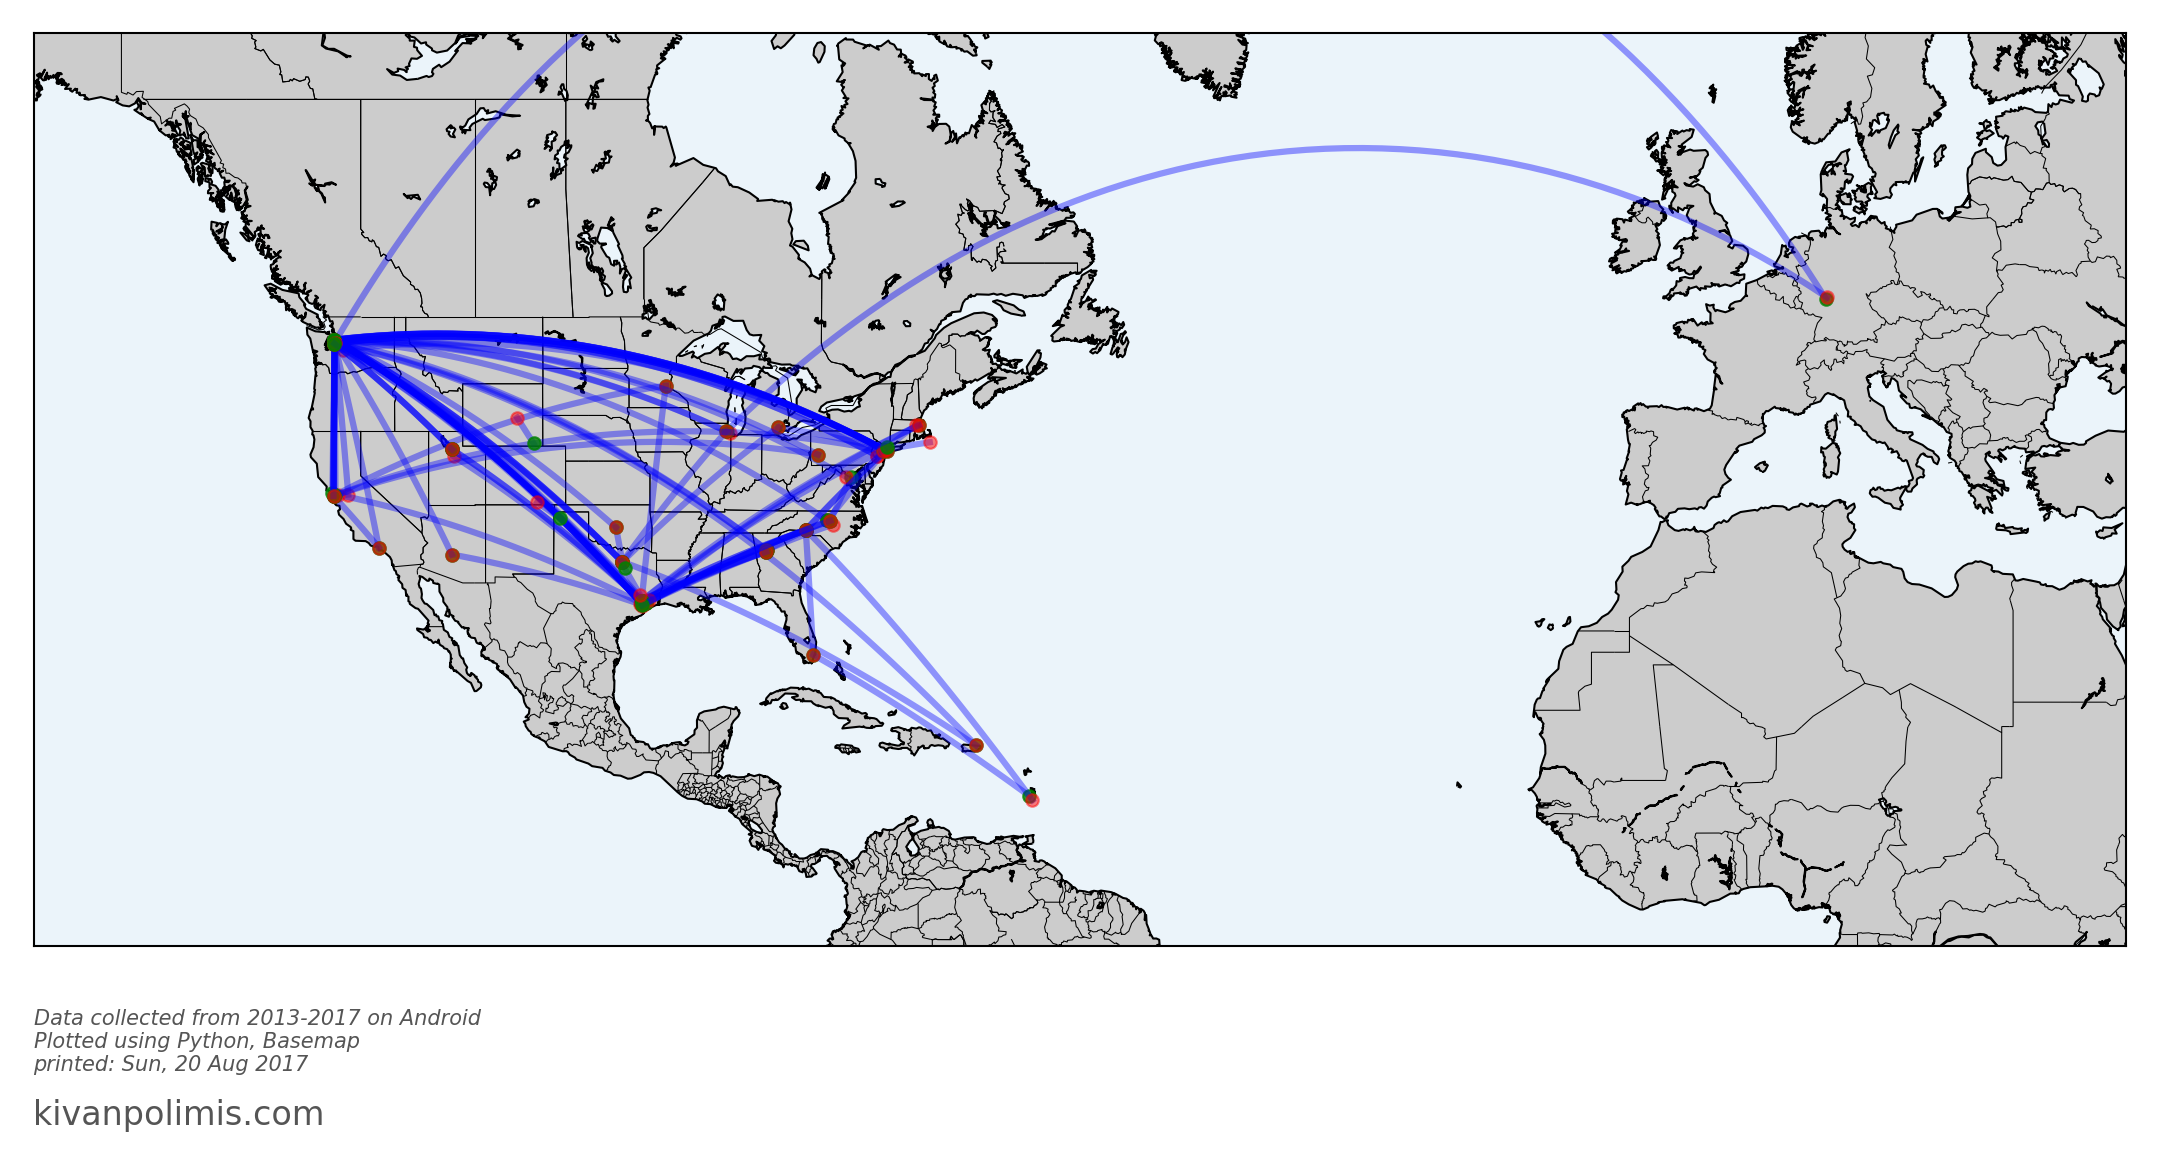

In [13]:
Image(filename='flights.png') 

You can draw entertaining conclusions from the flight visualization. For instance, you can see some popular layover locations, all those lines in/out of Seattle, plus a recent trip to Germany. And Basemap has made it so simple for us - no Shapefiles to import because all map information is included in the Basemap module.  

Calculate all the miles you have traveled in the years observed with a single line of code:

In [14]:
flights_in_miles = round(flights.distance.sum()*.621371) # distance column is in km, convert to miles
flights_in_miles

135255

In [15]:
print("{0} miles traveled from {1} to {2}".format(flights_in_miles, earliest_obs, latest_obs))

135255 miles traveled from 08-17-2013 to 08-19-2017


# Conclusion
You've now got the code to go ahead and reproduce these maps.  
I'm working on creating functions to automate these visualizations

## Potential future directions
* Figure out where you usually go on the weekends
* Calculate your fastest commute route
* measure the amount of time you spend driving vs. walking.

Download this [notebook](downloads/notebooks/map_of_flights.ipynb), or see a static view [here](https://github.com/kpolimis/kpolimis.github.io/blob/master/downloads/notebooks/map_of_flights.ipynb)

In [16]:
import time
print("last updated: {}".format(time.strftime("%a, %d %b %Y %H:%M", time.localtime())))

last updated: Sun, 20 Aug 2017 21:17
